In [97]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
# import albumentations as A
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
import pickle

In [32]:
# Pre M
combined_df = pd.read_csv("combined_df.csv")

In [34]:
combined_df.head()

,Unnamed: 0,Images,Masks,Classification Label,ID #,image
0,0,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,907,[[113 109 112 ... 86 41 18]\n [ 92 105 114 ...
1,1,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9081,[[ 7 6 5 ... 40 32 43]\n [ 6 6 5 ...
2,2,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9106,[[19 41 6 ... 13 6 2]\n [19 41 6 ... 26 17...
3,3,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9072,[[174 122 55 ... 75 77 86]\n [170 119 54 ...
4,4,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9060,[[197 170 154 ... 194 202 208]\n [ 71 22 14 ...


In [35]:
# Removing the newline literals from the saved dataframe

import re

combined_df = combined_df.replace(r'\n','', regex=True)
combined_df.head()

,Unnamed: 0,Images,Masks,Classification Label,ID #,image
0,0,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,907,[[113 109 112 ... 86 41 18] [ 92 105 114 .....
1,1,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9081,[[ 7 6 5 ... 40 32 43] [ 6 6 5 .....
2,2,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9106,[[19 41 6 ... 13 6 2] [19 41 6 ... 26 17 ...
3,3,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9072,[[174 122 55 ... 75 77 86] [170 119 54 .....
4,4,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9060,[[197 170 154 ... 194 202 208] [ 71 22 14 .....


## Model

### Test/Train Split

In [36]:
image_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(combined_df)):
    try:
      image = cv2.imread(combined_df['Images'][i])
      image = cv2.resize(image, (70, 70)) / 255.0
      if combined_df['Classification Label'][i] == "COVID":
        label = 1
      elif combined_df['Classification Label'][i] == "Viral Pneumonia":
        label = 2
      elif combined_df['Classification Label'][i] == "Lung_Opacity":
        label = 3
      else:
        label = 0
      image_data.append([image, label])
    except:
      continue


In [ ]:
df = pd.DataFrame(image_data)
df.to_pickle('image_label_df.pickle')

# START RUNNING CODE HERE AFTER IMPORTS

In [4]:
# Derived from above 'image_data' Python list

image_label_df = pd.read_pickle('image_label_df.pickle')
image_label_df.head()

,image,label
0,"[[[0.4588235294117647, 0.4588235294117647, 0.4...",0
1,"[[[0.027450980392156862, 0.027450980392156862,...",0
2,"[[[0.0, 0.0, 0.0], [0.10588235294117647, 0.105...",0
3,"[[[0.6862745098039216, 0.6862745098039216, 0.6...",0
4,"[[[0.7803921568627451, 0.7803921568627451, 0.7...",0


# Results Table

In [148]:
# create a dataframe showing all the parameters
input_parameter = pd.DataFrame({'kernel size': [(3, 3)] * 4 + [(5, 5)] * 3,
                                'pool size': [(2, 2)] * 2 + [(3, 3)] * 2 + [(2, 2)] + [(3, 3)] + [(2, 2)],
                                'optimizer': ['Adam'] + ['SGD'] + ['Adam'] + ['SGD'] + ['SGD'] + ['SGD'] + ['Adam'],
                                'training_accuracy': [0.8259, 0.6983, 0.8558, 0.6225, 0.6797, 0.6490, 0.8448],
                                'val_accuracy': [0.8677, 0.6846, 0.8653, 0.6237, 0.6562, 0.6072, 0.8677],
                                'test_accuracy': [0.8674, 0.6973, 0.8679, 0.6425, 0.6498, 0.5988, 0.8601]})
input_parameter

,kernel size,pool size,optimizer,training_accuracy,val_accuracy,test_accuracy
0,"(3, 3)","(2, 2)",Adam,0.8259,0.8677,0.8674
1,"(3, 3)","(2, 2)",SGD,0.6983,0.6846,0.6973
2,"(3, 3)","(3, 3)",Adam,0.8558,0.8653,0.8679
3,"(3, 3)","(3, 3)",SGD,0.6225,0.6237,0.6425
4,"(5, 5)","(2, 2)",SGD,0.6797,0.6562,0.6498
5,"(5, 5)","(3, 3)",SGD,0.6490,0.6072,0.5988
6,"(5, 5)","(2, 2)",Adam,0.8448,0.8677,0.8601


In [5]:
x = []
y = []

for n in range(len(image_label_df)):
  x.append(image_label_df['image'][n])
  y.append(image_label_df['label'][n])

# Converting to Numpy Array
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(15231, 70, 70, 3) (4232, 70, 70, 3) (1693, 70, 70, 3) (15231,) (4232,) (1693,)


# Model 0

In [90]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model0 = models.Sequential()
model0.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
model0.add(layers.MaxPooling2D((2, 2)))
model0.add(layers.Dropout(0.3))

model0.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model0.add(layers.MaxPooling2D((2, 2)))
model0.add(layers.Dropout(0.5))

model0.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model0.add(layers.Flatten())
model0.add(layers.Dense(units = 16, activation = 'relu'))
model0.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model0.add(layers.Dense(units = 4))

model0.compile(optimizer = 'adam',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 34, 34, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 64)       

In [91]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model0.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 36s 583ms/step - loss: 1.1000 - accuracy: 0.5145 - val_loss: 0.9138 - val_accuracy: 0.6202
Epoch 2/50
60/60 [==============================] - 35s 580ms/step - loss: 0.9229 - accuracy: 0.5887 - val_loss: 0.8351 - val_accuracy: 0.6356
Epoch 3/50
60/60 [==============================] - 35s 581ms/step - loss: 0.8471 - accuracy: 0.6258 - val_loss: 0.7674 - val_accuracy: 0.6675
Epoch 4/50
60/60 [==============================] - 34s 561ms/step - loss: 0.8234 - accuracy: 0.6462 - val_loss: 0.7634 - val_accuracy: 0.6822
Epoch 5/50
60/60 [==============================] - 34s 573ms/step - loss: 0.7888 - accuracy: 0.6545 - val_loss: 0.7324 - val_accuracy: 0.6881
Epoch 6/50
60/60 [==============================] - 34s 567ms/step - loss: 0.7718 - accuracy: 0.6633 - val_loss: 0.6721 - val_accuracy: 0.7082
Epoch 7/50
60/60 [==============================] - 34s 574ms/step - loss: 0.7401 - accuracy: 0.6824 - val_loss: 0.6662 - val_accuracy: 0.7336

In [92]:
ypred_train = model0.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model0.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model0.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 2s 15ms/step


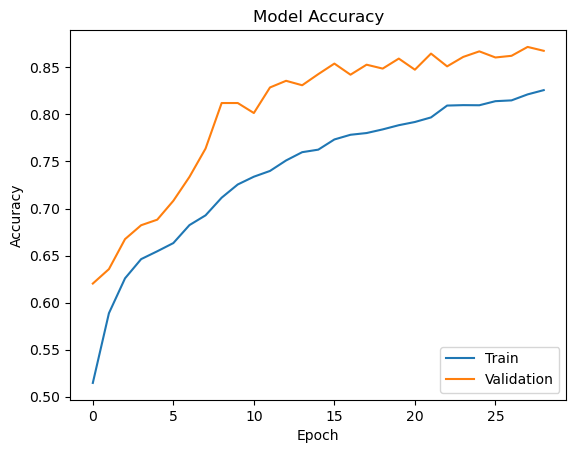

In [93]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

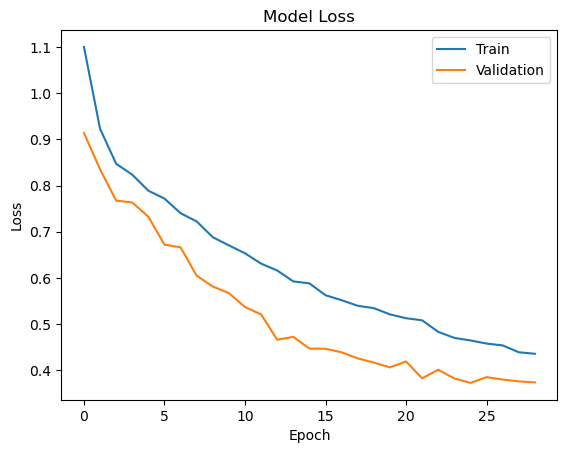

In [94]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

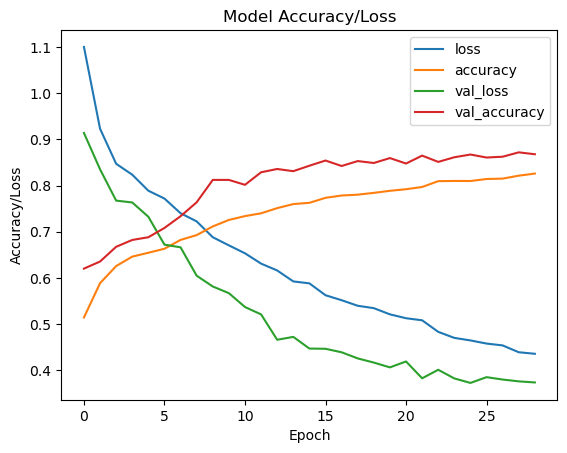

In [95]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [96]:
test_results = model0.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 2s 15ms/step - loss: 0.3819 - accuracy: 0.8674

Test Acc. 86.74%


# Model 1

In [60]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model1 = models.Sequential()
model1.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Dropout(0.3))

model1.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Dropout(0.5))

model1.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(units = 16, activation = 'relu'))
model1.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model1.add(layers.Dense(units = 4))

model1.compile(optimizer = 'SGD',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 34, 34, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)       

In [61]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model1.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 38s 621ms/step - loss: 1.2029 - accuracy: 0.4716 - val_loss: 1.1948 - val_accuracy: 0.5032
Epoch 2/50
60/60 [==============================] - 39s 657ms/step - loss: 1.1374 - accuracy: 0.4975 - val_loss: 1.1067 - val_accuracy: 0.6025
Epoch 3/50
60/60 [==============================] - 38s 627ms/step - loss: 1.0689 - accuracy: 0.5428 - val_loss: 1.0670 - val_accuracy: 0.6031
Epoch 4/50
60/60 [==============================] - 38s 633ms/step - loss: 1.0023 - accuracy: 0.5772 - val_loss: 0.9440 - val_accuracy: 0.6096
Epoch 5/50
60/60 [==============================] - 37s 618ms/step - loss: 0.9724 - accuracy: 0.5937 - val_loss: 0.9173 - val_accuracy: 0.6326
Epoch 6/50
60/60 [==============================] - 38s 627ms/step - loss: 0.9345 - accuracy: 0.6133 - val_loss: 0.9292 - val_accuracy: 0.6367
Epoch 7/50
60/60 [==============================] - 38s 629ms/step - loss: 0.9288 - accuracy: 0.6157 - val_loss: 0.9294 - val_accuracy: 0.6509

In [63]:
ypred_train = model1.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model1.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model1.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 2s 17ms/step


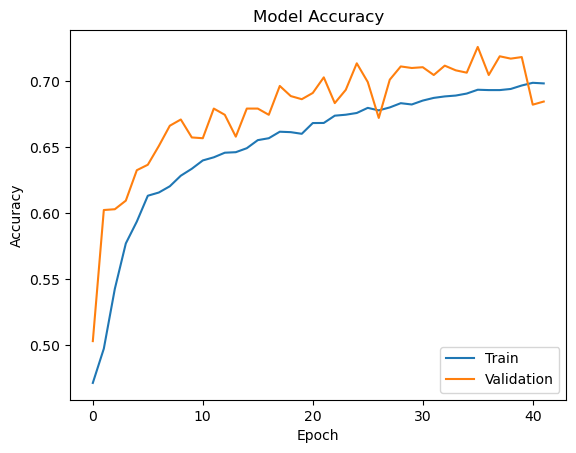

In [64]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

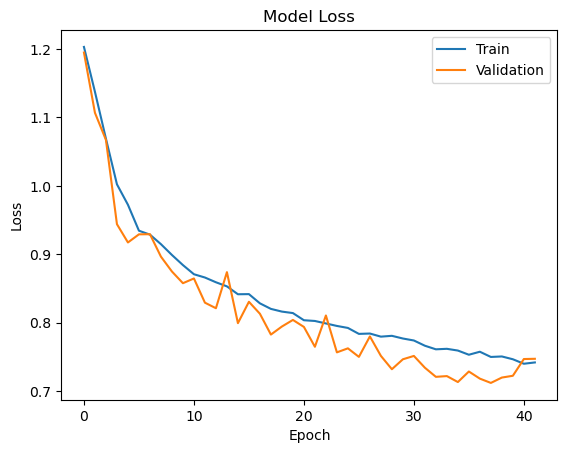

In [65]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

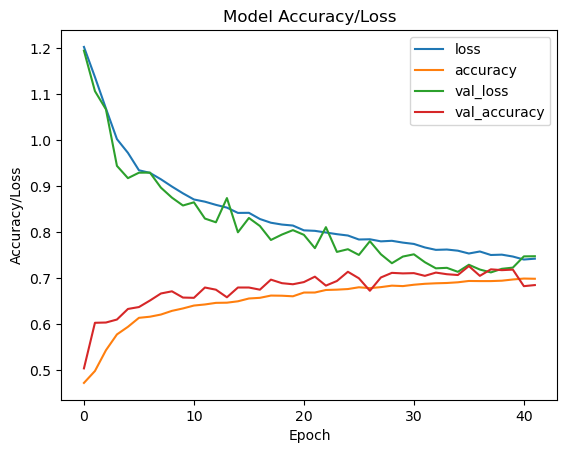

In [66]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [68]:
test_results = model1.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 2s 18ms/step - loss: 0.7313 - accuracy: 0.6973

Test Acc. 69.73%


# Model 2

In [98]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model2 = models.Sequential()
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(layers.Dropout(0.3))

model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(layers.Dropout(0.5))

model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(units = 16, activation = 'relu'))
model2.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model2.add(layers.Dense(units = 4))

model2.compile(optimizer = 'adam',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 128)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 22, 22, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 64)         

In [99]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model2.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 23s 365ms/step - loss: 1.1356 - accuracy: 0.5131 - val_loss: 0.9715 - val_accuracy: 0.6255
Epoch 2/50
60/60 [==============================] - 21s 357ms/step - loss: 0.9521 - accuracy: 0.6037 - val_loss: 0.8840 - val_accuracy: 0.6403
Epoch 3/50
60/60 [==============================] - 21s 352ms/step - loss: 0.8702 - accuracy: 0.6459 - val_loss: 0.8190 - val_accuracy: 0.6781
Epoch 4/50
60/60 [==============================] - 22s 364ms/step - loss: 0.8015 - accuracy: 0.6797 - val_loss: 0.7388 - val_accuracy: 0.7047
Epoch 5/50
60/60 [==============================] - 21s 351ms/step - loss: 0.7594 - accuracy: 0.6960 - val_loss: 0.6858 - val_accuracy: 0.7188
Epoch 6/50
60/60 [==============================] - 21s 351ms/step - loss: 0.7078 - accuracy: 0.7183 - val_loss: 0.6398 - val_accuracy: 0.7519
Epoch 7/50
60/60 [==============================] - 22s 360ms/step - loss: 0.6857 - accuracy: 0.7269 - val_loss: 0.6082 - val_accuracy: 0.7626

In [100]:
ypred_train = model2.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model2.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model2.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 1s 10ms/step


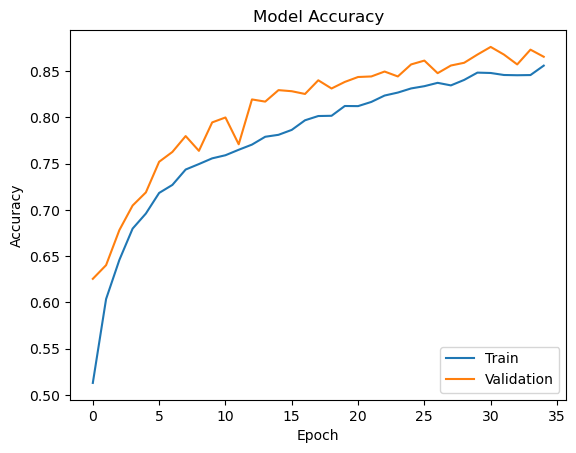

In [101]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

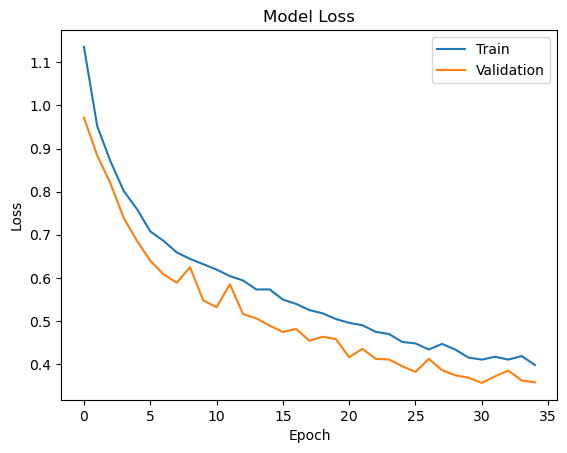

In [102]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

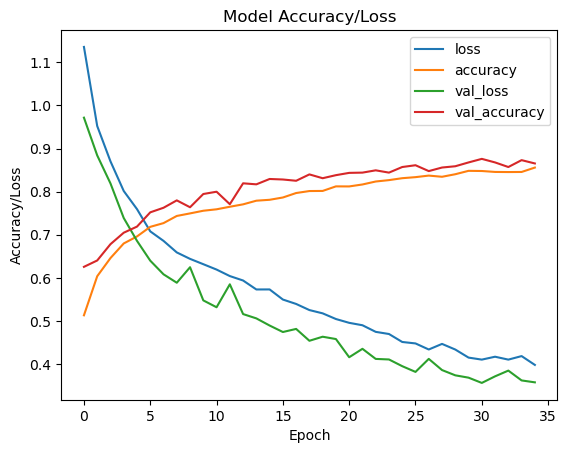

In [103]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [104]:
test_results = model2.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 1s 10ms/step - loss: 0.3414 - accuracy: 0.8679

Test Acc. 86.79%


# Model 3

In [105]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model3 = models.Sequential()
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
model3.add(layers.MaxPooling2D((3, 3)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPooling2D((3, 3)))
model3.add(layers.Dropout(0.5))

model3.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(units = 16, activation = 'relu'))
model3.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model3.add(layers.Dense(units = 4))

model3.compile(optimizer = 'SGD',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 128)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 6, 6, 64)         

In [106]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model3.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 22s 368ms/step - loss: 1.2658 - accuracy: 0.4417 - val_loss: 1.2043 - val_accuracy: 0.5044
Epoch 2/50
60/60 [==============================] - 25s 424ms/step - loss: 1.2106 - accuracy: 0.4763 - val_loss: 1.1850 - val_accuracy: 0.5044
Epoch 3/50
60/60 [==============================] - 22s 372ms/step - loss: 1.1979 - accuracy: 0.4848 - val_loss: 1.1748 - val_accuracy: 0.5044
Epoch 4/50
60/60 [==============================] - 21s 348ms/step - loss: 1.1808 - accuracy: 0.4913 - val_loss: 1.1595 - val_accuracy: 0.5038
Epoch 5/50
60/60 [==============================] - 22s 372ms/step - loss: 1.1648 - accuracy: 0.5020 - val_loss: 1.1463 - val_accuracy: 0.5127
Epoch 6/50
60/60 [==============================] - 21s 350ms/step - loss: 1.1509 - accuracy: 0.5134 - val_loss: 1.1287 - val_accuracy: 0.5487
Epoch 7/50
60/60 [==============================] - 21s 345ms/step - loss: 1.1301 - accuracy: 0.5294 - val_loss: 1.1112 - val_accuracy: 0.6102

In [107]:
ypred_train = model3.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model3.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model3.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 1s 10ms/step


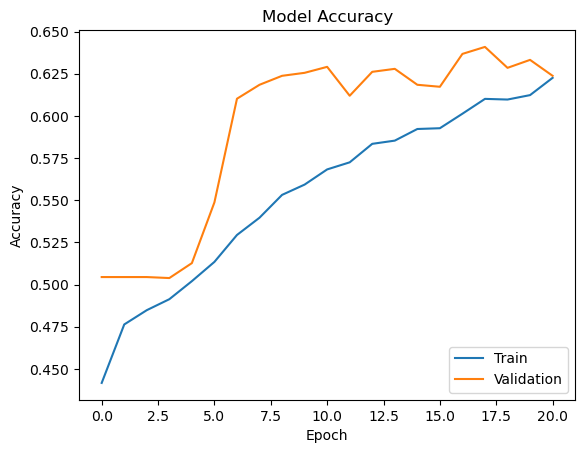

In [108]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

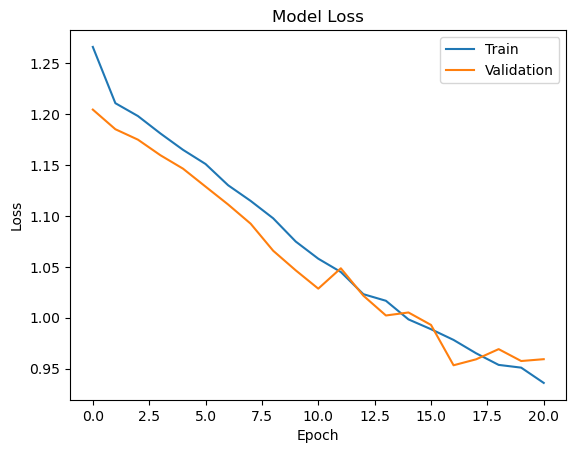

In [109]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

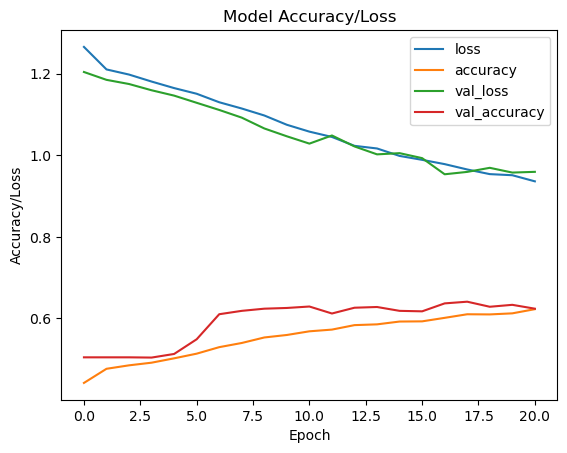

In [110]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [111]:
test_results = model3.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 2s 11ms/step - loss: 0.9359 - accuracy: 0.6425

Test Acc. 64.25%


# Model 4

In [116]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model4 = models.Sequential()
model4.add(layers.Conv2D(filters = 128, kernel_size = (5, 5), activation = 'relu', input_shape = (70, 70, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Dropout(0.3))

model4.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Dropout(0.5))

model4.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'))
model4.add(layers.Flatten())
model4.add(layers.Dense(units = 16, activation = 'relu'))
model4.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model4.add(layers.Dense(units = 4))

model4.compile(optimizer = 'SGD',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 66, 66, 128)       9728      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 33, 33, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 33, 33, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        204864    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)       

In [117]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model4.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 43s 711ms/step - loss: 1.2172 - accuracy: 0.4537 - val_loss: 1.2029 - val_accuracy: 0.5044
Epoch 2/50
60/60 [==============================] - 42s 708ms/step - loss: 1.1641 - accuracy: 0.4866 - val_loss: 1.1013 - val_accuracy: 0.5139
Epoch 3/50
60/60 [==============================] - 43s 719ms/step - loss: 1.0952 - accuracy: 0.5256 - val_loss: 1.0297 - val_accuracy: 0.6054
Epoch 4/50
60/60 [==============================] - 42s 697ms/step - loss: 1.0444 - accuracy: 0.5527 - val_loss: 0.9893 - val_accuracy: 0.6172
Epoch 5/50
60/60 [==============================] - 43s 711ms/step - loss: 1.0126 - accuracy: 0.5748 - val_loss: 0.9499 - val_accuracy: 0.6167
Epoch 6/50
60/60 [==============================] - 42s 706ms/step - loss: 0.9868 - accuracy: 0.5902 - val_loss: 0.9354 - val_accuracy: 0.6279
Epoch 7/50
60/60 [==============================] - 41s 691ms/step - loss: 0.9731 - accuracy: 0.5970 - val_loss: 0.9102 - val_accuracy: 0.6320

In [118]:
ypred_train = model4.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model4.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model4.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 3s 22ms/step


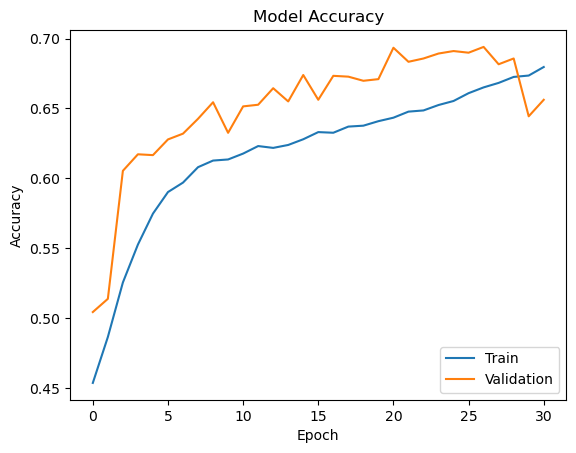

In [119]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

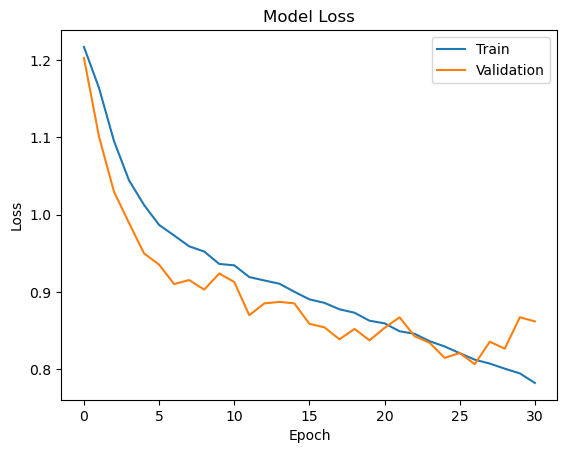

In [120]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

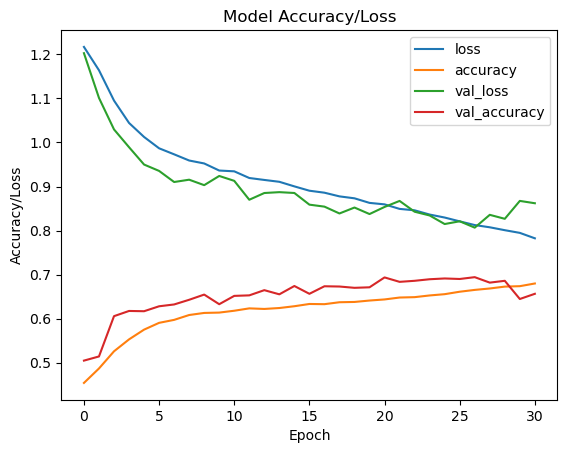

In [121]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [122]:
test_results = model4.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 3s 22ms/step - loss: 0.8709 - accuracy: 0.6498

Test Acc. 64.98%


# Model 5

In [123]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model5 = models.Sequential()
model5.add(layers.Conv2D(filters = 128, kernel_size = (5, 5), activation = 'relu', input_shape = (70, 70, 3)))
model5.add(layers.MaxPooling2D((3, 3)))
model5.add(layers.Dropout(0.3))

model5.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'))
model5.add(layers.MaxPooling2D((3, 3)))
model5.add(layers.Dropout(0.5))

model5.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(units = 16, activation = 'relu'))
model5.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model5.add(layers.Dense(units = 4))

model5.compile(optimizer = 'SGD',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 66, 66, 128)       9728      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 22, 22, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 18, 18, 64)        204864    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 64)         

In [124]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model5.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 27s 436ms/step - loss: 1.2641 - accuracy: 0.4544 - val_loss: 1.2048 - val_accuracy: 0.5044
Epoch 2/50
60/60 [==============================] - 26s 427ms/step - loss: 1.2087 - accuracy: 0.4711 - val_loss: 1.1814 - val_accuracy: 0.5044
Epoch 3/50
60/60 [==============================] - 26s 427ms/step - loss: 1.1857 - accuracy: 0.4819 - val_loss: 1.1481 - val_accuracy: 0.5038
Epoch 4/50
60/60 [==============================] - 25s 412ms/step - loss: 1.1520 - accuracy: 0.5065 - val_loss: 1.1238 - val_accuracy: 0.6108
Epoch 5/50
60/60 [==============================] - 25s 413ms/step - loss: 1.1163 - accuracy: 0.5303 - val_loss: 1.1023 - val_accuracy: 0.6078
Epoch 6/50
60/60 [==============================] - 26s 430ms/step - loss: 1.0766 - accuracy: 0.5613 - val_loss: 1.0428 - val_accuracy: 0.6202
Epoch 7/50
60/60 [==============================] - 25s 422ms/step - loss: 1.0501 - accuracy: 0.5771 - val_loss: 1.0390 - val_accuracy: 0.6202

In [125]:
ypred_train = model5.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model5.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model5.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 2s 13ms/step


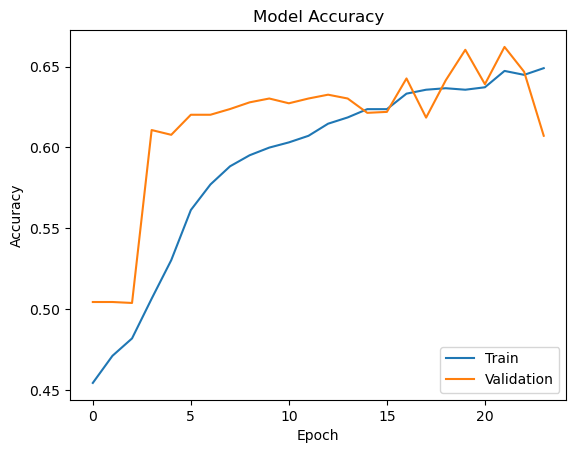

In [126]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

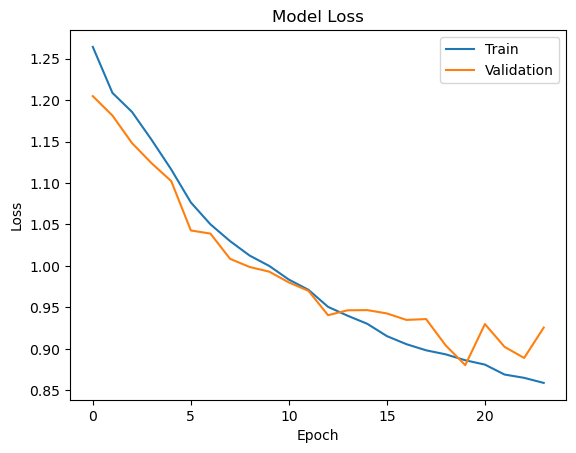

In [127]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

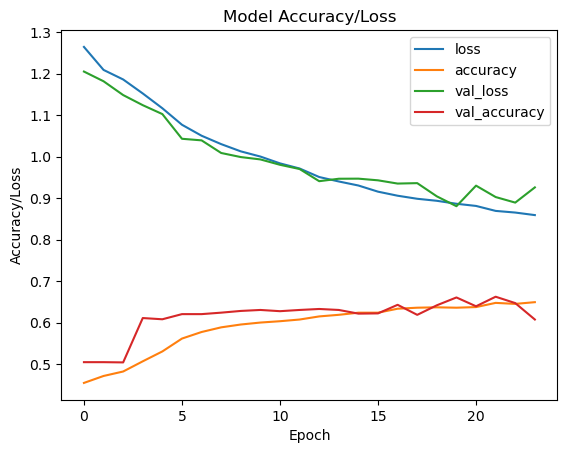

In [128]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [129]:
test_results = model5.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 2s 13ms/step - loss: 0.9354 - accuracy: 0.5988

Test Acc. 59.88%


# Model 6

In [139]:
# For multiclass, we need units = 4 and the acitvation function should be softmax instead of sigmoid
# keep sparse categorical crossentropy for the loss
# make sure to use relu for activation in the intermediate layers
# maybe the input shape needs to be fixed

model6 = models.Sequential()
model6.add(layers.Conv2D(filters = 128, kernel_size = (5, 5), activation = 'relu', input_shape = (70, 70, 3)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Dropout(0.3))

model6.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Dropout(0.5))

model6.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(units = 16, activation = 'relu'))
model6.add(layers.Dropout(0.2))

# Output layer; this units needs to match the number of classes we have
model6.add(layers.Dense(units = 4))

model6.compile(optimizer = 'adam',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 66, 66, 128)       9728      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 33, 33, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 33, 33, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 64)        204864    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 14, 14, 64)       

In [140]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = model6.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
60/60 [==============================] - 44s 727ms/step - loss: 1.0905 - accuracy: 0.5504 - val_loss: 0.9491 - val_accuracy: 0.6048
Epoch 2/50
60/60 [==============================] - 43s 714ms/step - loss: 0.9306 - accuracy: 0.6170 - val_loss: 0.8131 - val_accuracy: 0.6539
Epoch 3/50
60/60 [==============================] - 44s 729ms/step - loss: 0.8475 - accuracy: 0.6325 - val_loss: 0.7864 - val_accuracy: 0.6421
Epoch 4/50
60/60 [==============================] - 44s 730ms/step - loss: 0.8049 - accuracy: 0.6554 - val_loss: 0.6974 - val_accuracy: 0.7112
Epoch 5/50
60/60 [==============================] - 42s 706ms/step - loss: 0.7725 - accuracy: 0.6733 - val_loss: 0.6620 - val_accuracy: 0.7265
Epoch 6/50
60/60 [==============================] - 43s 715ms/step - loss: 0.7518 - accuracy: 0.6771 - val_loss: 0.6417 - val_accuracy: 0.7330
Epoch 7/50
60/60 [==============================] - 43s 717ms/step - loss: 0.7272 - accuracy: 0.6910 - val_loss: 0.6398 - val_accuracy: 0.7519

In [141]:
ypred_train = model6.predict(x_train)
ypred_train = np.argmax(ypred_train, axis = 1)

ypred_val = model6.predict(x_val)
ypred_val = np.argmax(ypred_val, axis = 1)

ypred_test = model6.predict(x_test)
ypred_test = np.argmax(ypred_test, axis = 1)

133/133 [==============================] - 3s 22ms/step


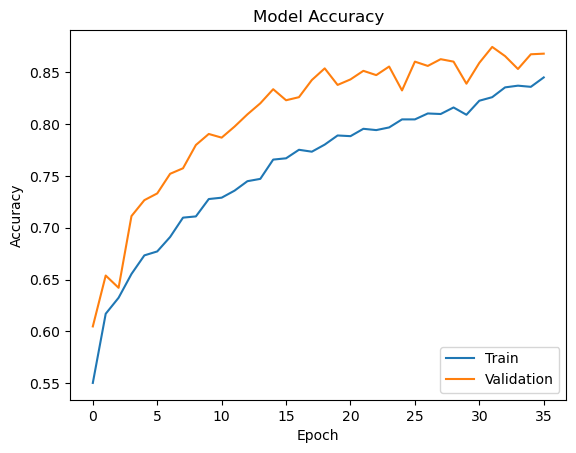

In [142]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

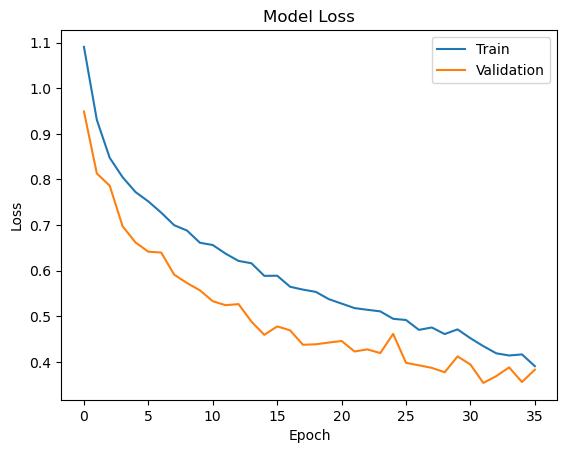

In [143]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

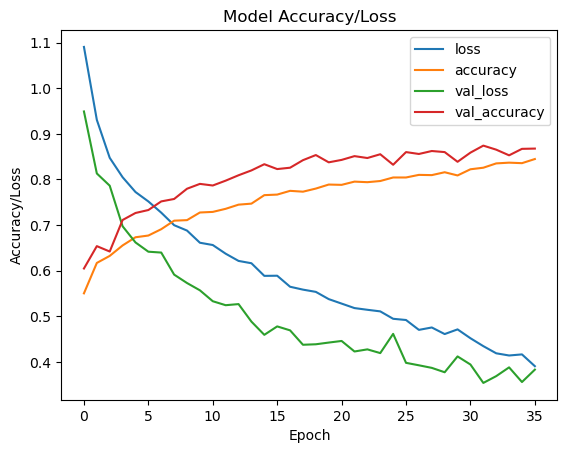

In [144]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [145]:
test_results = model6.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

133/133 [==============================] - 3s 22ms/step - loss: 0.3944 - accuracy: 0.8601

Test Acc. 86.01%
